In [101]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [14]:
# Load Dataset
csv_files = files.upload()
base_df = pd.read_csv(list(csv_files.keys())[0])

Saving NN_Dataset.csv to NN_Dataset (3).csv


In [85]:
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

In [91]:
# Split into features and labels
position_features = base_df.copy()
position_labels = position_features[['True_Local_Position_X', 'True_Local_Position_Y']].copy()
position_features = position_features.drop(['True_Local_Position_X', 'True_Local_Position_Y', 'Dataset', 'Tether_Length', 'Sonar_Altitude'], axis=1)
position_features.head()

,Wind_Speed,Wind_Direction,Craft_Direction,Craft_Pitch,Craft_Roll,ATS_Pitch,ATS_Roll,Lidar_Altitude
0,1964,-11657,18163,57,-114,-31,-39,70
1,1964,-11657,18203,57,-114,-31,-38,70
2,1960,-11717,18203,114,0,-17,-43,70
3,1935,-11883,19752,114,0,-14,-30,70
4,1894,-12105,19752,114,171,0,-45,76


In [92]:
#Split into training and test data
feature_train, feature_test, label_train, label_test = train_test_split(
    position_features, position_labels,
    test_size=0.33, random_state=42)

In [128]:
# scale the input data
feature_train_scaled, feature_test_scaled = scale_datasets(feature_train, feature_test)

In [144]:
# Build Model
position_model = tf.keras.Sequential([
  layers.Dense(64, kernel_initializer='normal', activation='relu'),
  layers.Dense(128, kernel_initializer='normal', activation='relu'),
  layers.Dense(64, kernel_initializer='normal', activation='relu'),
  layers.Dense(2, kernel_initializer='normal', activation='linear')
])

In [145]:
# Compile Mode
loss_func = tf.keras.losses.MeanSquaredLogarithmicError()
optimizer_func = tf.keras.optimizers.Adam()
position_model.compile(loss=loss_func,
                       optimizer=optimizer_func,
                       metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()],)

In [146]:
#Run Model
epochs_to_run = 20
batch_size=64
history = position_model.fit(feature_train_scaled.values,
                   label_train.values,
                   batch_size=batch_size,
                   epochs=epochs_to_run,
                   validation_data=(feature_test_scaled.values, label_test.values),
                   )

Epoch 1/20
100/100 [==============================] - 2s 7ms/step - loss: 0.0063 - mean_squared_logarithmic_error: 0.0063 - val_loss: 0.0034 - val_mean_squared_logarithmic_error: 0.0034
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0029 - mean_squared_logarithmic_error: 0.0029 - val_loss: 0.0025 - val_mean_squared_logarithmic_error: 0.0025
Epoch 3/20
100/100 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_squared_logarithmic_error: 0.0023 - val_loss: 0.0020 - val_mean_squared_logarithmic_error: 0.0020
Epoch 4/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_squared_logarithmic_error: 0.0019 - val_loss: 0.0018 - val_mean_squared_logarithmic_error: 0.0018
Epoch 5/20
100/100 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_squared_logarithmic_error: 0.0017 - val_loss: 0.0019 - val_mean_squared_logarithmic_error: 0.0019
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - lo

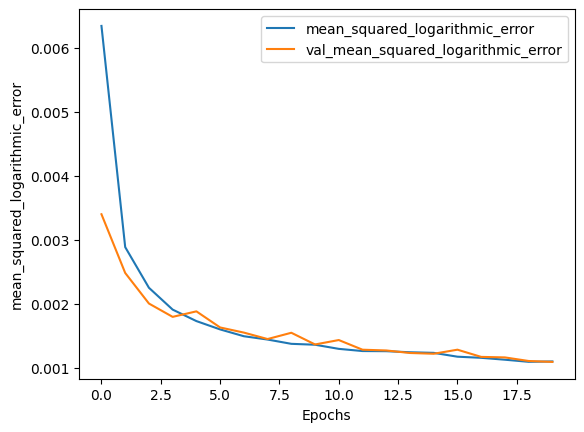

In [147]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

99/99 [==============================] - 0s 2ms/step


<Axes: >

<Figure size 640x480 with 0 Axes>

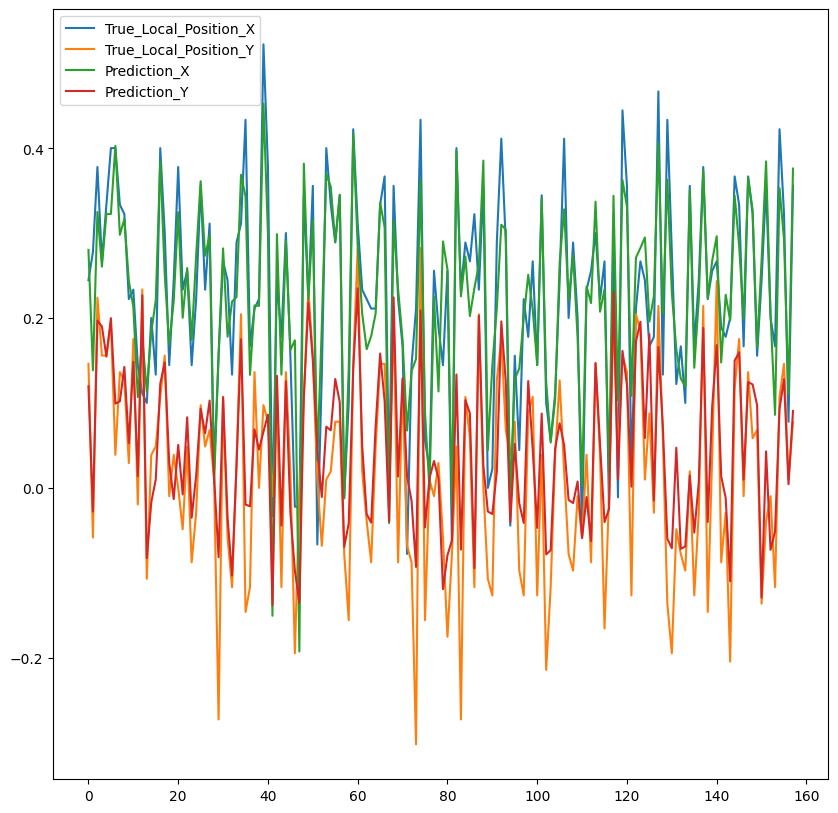

In [162]:
comparison_df = label_test.copy()
predictions = position_model.predict(feature_test_scaled.values)
predictions = predictions.transpose()
comparison_df["Prediction_X"] = predictions[0]
comparison_df["Prediction_Y"] = predictions[1]
comparison_df = comparison_df.reset_index(drop=True)
plt.figure()
comparison_df.sample(frac=0.05).reset_index(drop=True).plot(figsize=(10, 10))